In [1]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.patches as patches
from matplotlib import cm

In [3]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)
ORDER = [0, 2, 3, 1]
version = 'v4'

In [4]:
all_age = loadmat(f'../../all_age_gender_log_{version}.mat')['all_age_gender'][0]
len(all_age)
all_jid_aut = loadmat(f'../../all_jid_aut_{version}.mat')['all_jid_aut'][0]
len(all_jid_aut)

4

# S1
example scatter plot pixel to pixel

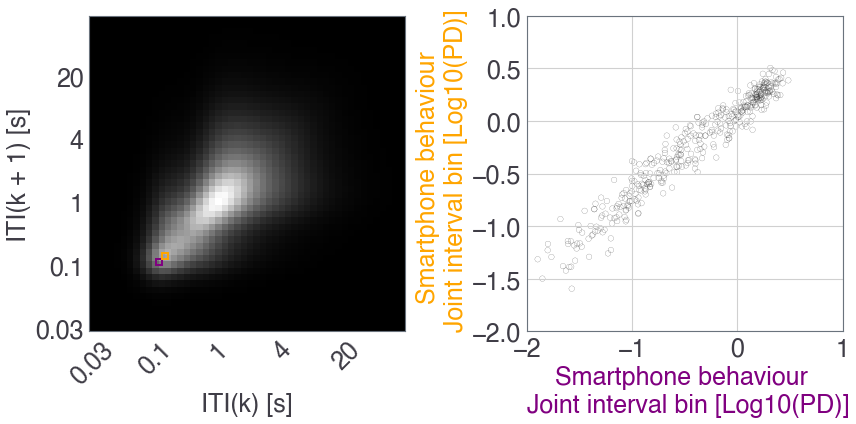

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

IDX = 0

self_res = all_jid_aut[1].flat[0][0].flat[0]
A = all_jid_aut[0].flat[0][1].squeeze()

im = ax[0].imshow(10 ** np.mean(A, 0).reshape(50, 50), aspect='auto', cmap='gray')

ax[0].invert_yaxis()
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(labels)
ax[0].xaxis.set_tick_params(rotation=45)
ax[0].set_yticks(ticks)
ax[0].set_yticklabels(labels)
ax[0].set_xlabel('ITI(k) [s]')
ax[0].set_ylabel('ITI(k + 1) [s]')
ax[0].grid(False)
# divider = make_axes_locatable(ax[0])
# cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
# fig.add_axes(cax)
# cb = fig.colorbar(im, cax=cax, orientation="horizontal")
# cb.ax.xaxis.set_ticks_position('top')

X1, Y1 = 10, 10
X2, Y2 = 11, 11

rect1 = patches.Rectangle((X1, Y1), 1, 1, linewidth=2, edgecolor='purple', facecolor='none')
rect2 = patches.Rectangle((X2, Y2), 1, 1, linewidth=2, edgecolor='orange', facecolor='none')
ax[0].add_patch(rect1)
ax[0].add_patch(rect2)

idx1 = X1 * 50 + Y1
idx2 = X2 * 50 + Y2
ax[1].scatter(A[:, idx1], A[:, idx2], facecolors='none', edgecolors='k')
ax[1].set_xlim([-2 , 1])
ax[1].set_ylim([-2 , 1])
ax[1].set_xlabel("Smartphone behaviour \n Joint interval bin [Log10(PD)]")
ax[1].xaxis.label.set_color('purple')
ax[1].set_ylabel("Smartphone behaviour \n Joint interval bin [Log10(PD)]")
ax[1].yaxis.label.set_color('orange')
plt.tight_layout()
plt.savefig('figure_2_supplementary_i.pdf', transparent=True)

# S2 - autocorrelation on pixel value

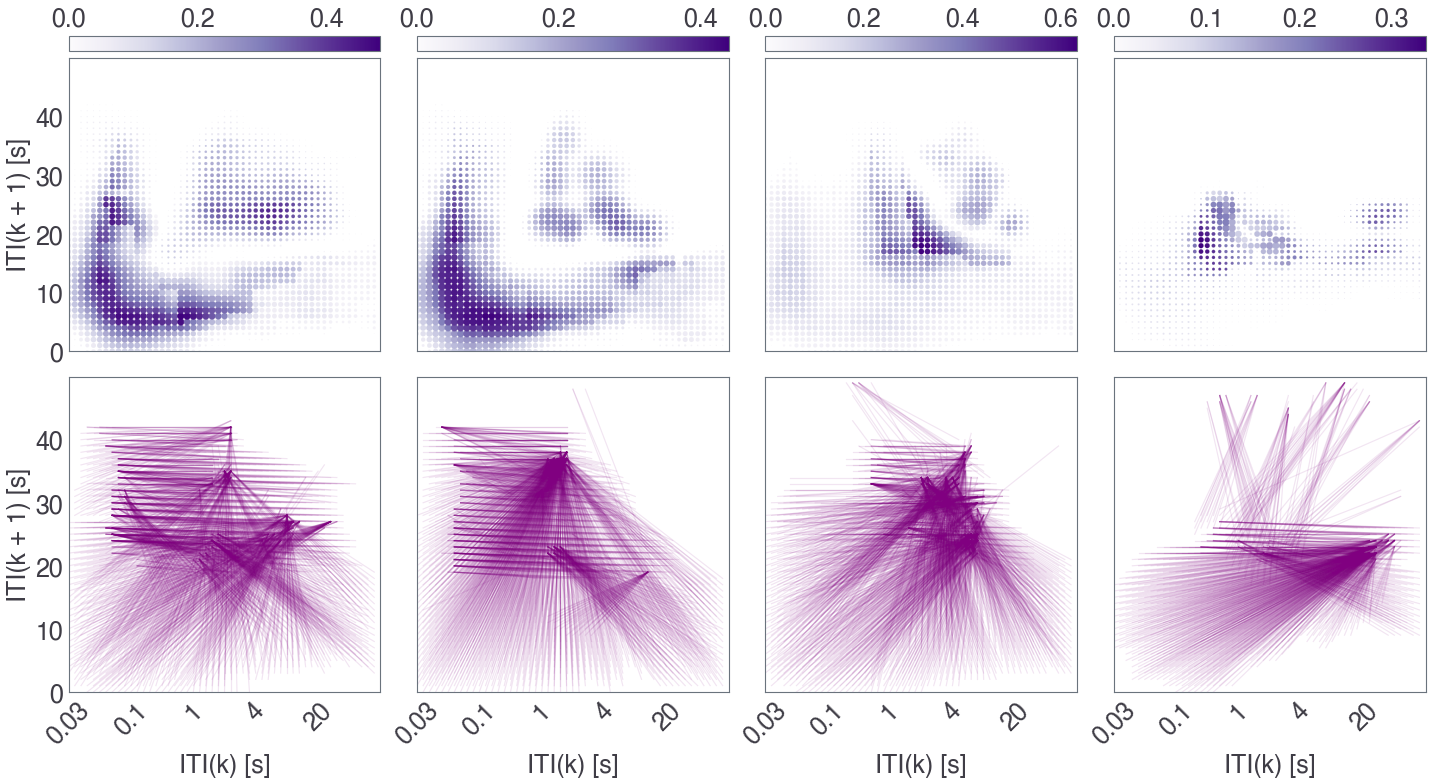

In [15]:
fig, ax = plt.subplots(2, 4, figsize=(20, 11), sharex=True, sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

min_dist_pix = 0;
th_dist = min_dist_pix * np.sqrt(2);
th_R = 0;
th_F = 0;

X = np.arange(2500) % 50;
Y = np.arange(2500) // 50;

for kk in range(4):
    to_avg_r2 = [[] for _ in range(2500)]
    n_flips = np.zeros((2500,))
    n_non_flips = np.zeros((2500,))
    best_r2 = np.zeros((2500, 6))
    
    # FOR SIGN AGE PIXEL
    val = all_age[ORDER[kk]].flat[0][5].flat[0]
    masks = [m[0] for m in val[0]]
    mask_uni = masks[0]
    
    # AUT
    aut = all_jid_aut[ORDER[kk]].flat[0][0].flat[0]
    mask_aut = aut[0]
    p_vals_aut = aut[1]
    f_vals_aut = aut[2] 
    r_vals_aut = aut[3]
    r2_vals_aut = aut[4]
    betas_aut = aut[5]

    for i in range(2500):
        for j in range(i + 1, 2500):
            if (abs(r_vals_aut[i, j]) > th_R) & (f_vals_aut[i, j] > th_F) & (mask_aut[i, j] == 1) & ((mask_uni[i]) | (mask_uni[j])):
                x1 = i % 50
                y1 = i // 50
                x2 = j % 50
                y2 = j // 50
                # is there a flip
                # count percentage of non-flips
                if betas_aut[i, j, 0] < 0:
                    if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) > th_dist:
                        _r2 = r2_vals_aut[i, j]
                        n_flips[i] += 1
                        to_avg_r2[i].append(_r2)
                        if _r2 > best_r2[i, 0]:
                            best_r2[i, 0] = _r2
                            best_r2[i, 1] = x1
                            best_r2[i, 2] = y1
                            best_r2[i, 3] = x2
                            best_r2[i, 4] = y2
                            best_r2[i, 5] = 1
                else:
                    if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) > th_dist:
                        n_non_flips[i] += 1
                    
    compt_r2 = np.array([np.max(i) if len(i) > 0 else 0 for i in to_avg_r2])
    
    im = ax[0][kk].scatter(X, Y, s=n_flips / np.max(n_flips) * 50, c=compt_r2, cmap='Purples')
    divider = make_axes_locatable(ax[0][kk])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')

    for i in range(2500):
        if best_r2[i, 5] == 1:
            x1, y1, x2, y2 = best_r2[i, 1:5]
            ax[1][kk].plot([x1, x2], [y1, y2], '-', color='purple', alpha=0.1)

    for i in range(2):
        ax[i][kk].grid(False)
        ax[i][kk].set_xticks(ticks)
        ax[i][kk].set_xticklabels(labels)
        ax[i][kk].xaxis.set_tick_params(rotation=45)
        ax[i][kk].set_yticks(ticks)
        ax[i][kk].set_xlim([0, 50])
        ax[i][kk].set_ylim([0, 50])
        if i == 1:
            ax[i][kk].set_xlabel('ITI(k) [s]')
        if kk == 0:
            ax[i][kk].set_ylabel('ITI(k + 1) [s]')
plt.tight_layout()
plt.savefig('figure_2_supplementary_ii.pdf', transparent=True)

# Panel a - example pixel residual on age

[-0.02768853  0.0135328  -0.91335285]
[ 0.00997595 -0.03274954 -2.44720359]
[4.7839883e-01 1.4521723e-16]
0.0001494451847351419


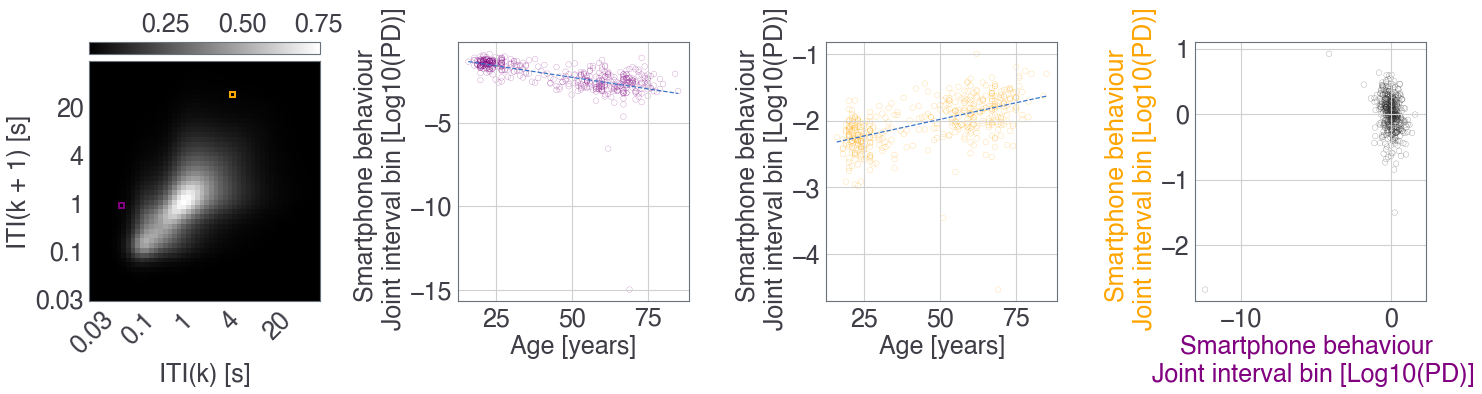

In [67]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5.5))

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

val = all_age[0].flat[0][5].flat[0]
mdl = val[2]
A = val[3].squeeze()
B = val[4].squeeze()

betas = np.zeros((2500, 3))

for j, obj in enumerate(mdl):
    pixel = obj.flat[0][0][0]
    betas[j] = pixel[1].squeeze()

residual = all_age[0].flat[0][6].flat[0][6]
betas_res = all_age[0].flat[0][6].flat[0][5]
p_vals_res = all_age[0].flat[0][6].flat[0][1]

im = ax[0].imshow(10 ** np.mean(A, 0).reshape(50, 50), aspect='auto', cmap='gray')
ax[0].invert_yaxis()
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(labels)
ax[0].xaxis.set_tick_params(rotation=45)
ax[0].set_yticks(ticks)
ax[0].set_yticklabels(labels)
ax[0].set_xlabel('ITI(k) [s]')
ax[0].set_ylabel('ITI(k + 1) [s]')
ax[0].grid(False)
divider = make_axes_locatable(ax[0])
cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.xaxis.set_ticks_position('top')

# ((6, 19), (30, 42))
X1, Y1 = 6, 19
X2, Y2 = 30, 42

rect1 = patches.Rectangle((X1, Y1), 1, 1, linewidth=2, edgecolor='purple', facecolor='none')
rect2 = patches.Rectangle((X2, Y2), 1, 1, linewidth=2, edgecolor='orange', facecolor='none')
ax[0].add_patch(rect1)
ax[0].add_patch(rect2)

MM = B @ betas.T

for i, (_X, _Y, _color) in enumerate(zip([X1, X2], [Y1, Y2], ['purple', 'orange'])):

    idx1 = _Y * 50 + _X
    _y = A[:, idx1]
    _x = B[:, 0]
    print(betas[idx1])
    _k = betas[idx1]
    mm = MM[:, idx1]
    _min = np.argmin(_x)
    _max = np.argmax(_x)
    ax[i + 1].scatter(_x, _y, facecolors='none', edgecolors=_color)
    ax[i + 1].plot([_x[_min], _x[_max]], [mm[_min], mm[_max]], '--b')
#     ax[i + 1].plot([min(_x), max(_x)], np.array([min(_x), max(_x)]) * _k[0] + _k[2], '--b')
#     ax[i + 1].set_ylim([-2, 1])

# idx1 = X1 * 50 + Y1
# idx2 = X2 * 50 + Y2
idx1 = Y1 * 50 + X1
idx2 = Y2 * 50 + X2
print(betas_res[idx1, idx2])
print(p_vals_res[idx1, idx2])
ax[3].scatter(residual[:, idx1], residual[:, idx2], facecolors='none', edgecolors='k')
# ax[3].set_xlim([-2 , 2])
# ax[3].set_ylim([-2 , 2])

ax[1].set_xlabel("Age [years]")
ax[1].set_ylabel("Smartphone behaviour \n Joint interval bin [Log10(PD)]")
ax[2].set_xlabel("Age [years]")
ax[2].set_ylabel("Smartphone behaviour \n Joint interval bin [Log10(PD)]")

ax[3].set_xlabel("Smartphone behaviour \n Joint interval bin [Log10(PD)]")
ax[3].xaxis.label.set_color('purple')
ax[3].set_ylabel("Smartphone behaviour \n Joint interval bin [Log10(PD)]")
ax[3].yaxis.label.set_color('orange')

plt.tight_layout()
plt.savefig('figure_2_panel_a.pdf', transparent=True)

(array([  1.,   0.,   0.,   1.,   0.,  13.,  91., 219.,  90.,   5.]),
 array([-2.6815009 , -2.3212648 , -1.9610287 , -1.60079259, -1.24055649,
        -0.88032039, -0.52008429, -0.15984819,  0.20038791,  0.56062401,
         0.92086011]),
 <BarContainer object of 10 artists>)

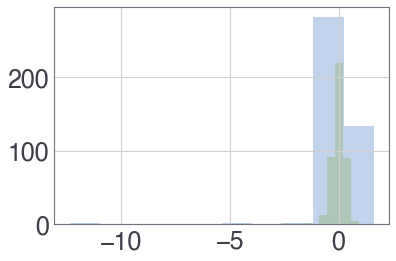

In [69]:
plt.hist(residual[:, idx1], alpha=0.3)
plt.hist(residual[:, idx2], alpha=0.3)

# Panel b

In [52]:
all_age = loadmat(f'../../all_age_gender_log_{version}.mat')['all_age_gender'][0]

In [53]:
i = 0
val = all_age[i].flat[0][5].flat[0]
print(len(val))
residual = all_age[i].flat[0][6].flat[0]
print(len(residual))

5
7


###### Alternative 0
real flip defined as if the aging process is flipped between two pixels 
4 cases:

    - p1 b_age > 0 & p2 b_age > 0 == flip if b_res < 0
    - p1 b_age < 0 & p2 b_age < 0 == flip if b_res < 0
    - p1 b_age > 0 & p2 b_age < 0 == flip if b_res > 0
    - p1 b_age < 0 & p2 b_age > 0 == flip if b_res > 0

((6, 19), (30, 42))
(-0.027688532270140294, 0.00997594670554188)
0.47839883046616005
(0.34116548756192033, 0.3056730100871457)


ValueError: 

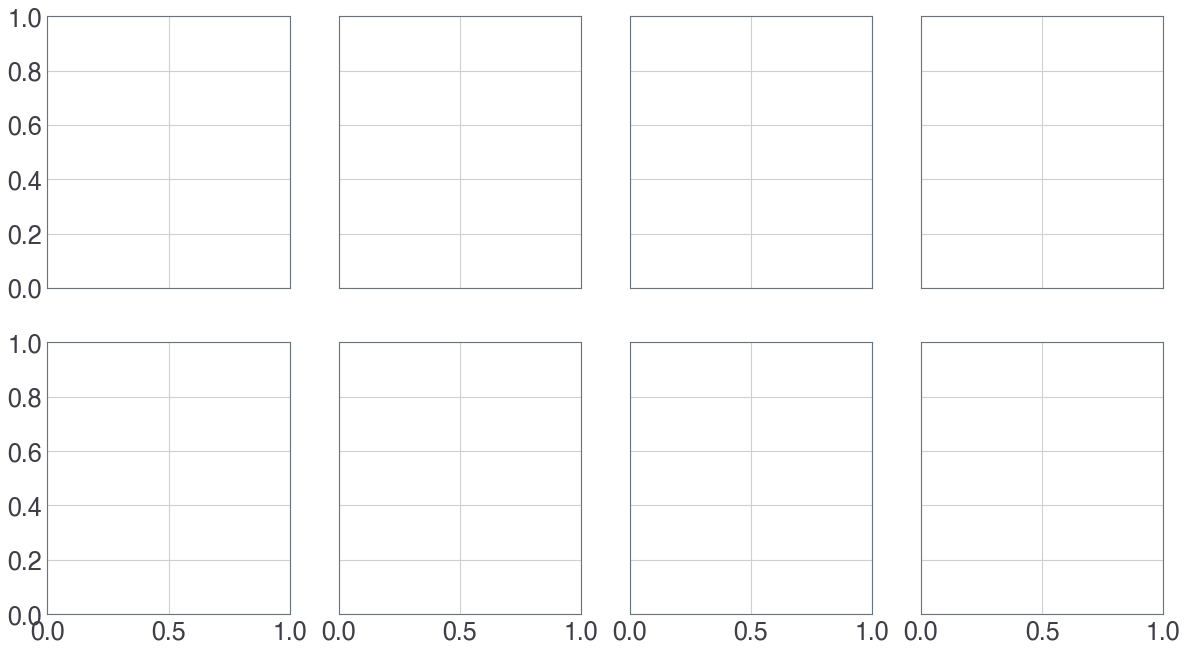

In [59]:
fig, ax = plt.subplots(2, 4, figsize=(20, 11), sharex=True, sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

min_dist_pix = 0;
th_dist = min_dist_pix * np.sqrt(2);
th_R = 0;
th_F = 0;
th_R2 = 0.3;
X = np.arange(2500) % 50;
Y = np.arange(2500) // 50;
n_non_flips = np.zeros((2500, 4))

for kk in range(1):
    to_avg_r2 = [[] for _ in range(2500)]
    n_flips = np.zeros((2500,))
    best_r2 = np.zeros((2500, 6))
    # VALUES
    val = all_age[ORDER[kk]].flat[0][5].flat[0]
    masks = [m[0] for m in val[0]]
    mask_uni = masks[0]
    mask_full = masks[-1]
    mdl = val[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[3][0][0]
        f_full[j] = pixel[4][0][0]
        p_full[j] = pixel[6][0][0]
        betas[j] = pixel[1].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[2]

    # RESIDUALS
    residual = all_age[ORDER[kk]].flat[0][6].flat[0]
    mask_res = residual[0]
    p_vals_res = residual[1]
    f_vals_res = residual[2] 
    r_vals_res = residual[3]
    r2_vals_res = residual[4]
    betas_res = residual[5]

    for i in range(2500):
        for j in range(i + 1, 2500):
            if (r2_full[i] > th_R2) & (r2_full[j] > th_R2) & (abs(r_vals_res[i, j]) > th_R) & (f_vals_res[i, j] > th_F) & (mask_res[i, j] == 1) & ((mask_uni[i]) | (mask_uni[j])):
                x1 = i % 50
                y1 = i // 50
                x2 = j % 50
                y2 = j // 50
                # is there a flip
                # count percentage of non-flips
                if ((np.sign(betas[i, 0]) == np.sign(betas[j, 0])) & (np.sign(betas_res[i, j, 0]) < 0) ) | ((np.sign(betas[i, 0]) != np.sign(betas[j, 0])) & (np.sign(betas_res[i, j, 0]) > 0) ):
                    print(((x1, y1), (x2, y2)))
                    print((betas[i, 0], betas[j, 0]))
                    print(betas_res[i, j, 0])
                    print((r2_full[i], r2_full[j]))
                    raise ValueError("")
                    if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) > th_dist:
                        _r2 = r2_vals_res[i, j]
                        n_flips[i] += 1
                        to_avg_r2[i].append(_r2)
                        if _r2 > best_r2[i, 0]:
                            best_r2[i, 0] = _r2
                            best_r2[i, 1] = x1
                            best_r2[i, 2] = y1
                            best_r2[i, 3] = x2
                            best_r2[i, 4] = y2
                            best_r2[i, 5] = 1
                else:
                    if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) > th_dist:
                        n_non_flips[i, kk] += 1
                        
    compt_r2 = np.array([np.max(i) if len(i) > 0 else 0 for i in to_avg_r2])
    
    im = ax[0][kk].scatter(X, Y, s=n_flips / np.max(n_flips) * 50, c=compt_r2, cmap='Purples')
    divider = make_axes_locatable(ax[0][kk])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')

    for i in range(2500):
        if best_r2[i, 5] == 1:
            x1, y1, x2, y2 = best_r2[i, 1:5]
            ax[1][kk].plot([x1, x2], [y1, y2], '-', color='purple', alpha=0.1)

# legende the size


    for i in range(2):
        ax[i][kk].grid(False)
        ax[i][kk].set_xticks(ticks)
        ax[i][kk].set_xticklabels(labels)
        ax[i][kk].xaxis.set_tick_params(rotation=45)
        ax[i][kk].set_yticks(ticks)
        ax[i][kk].set_yticklabels(labels)
        ax[i][kk].set_xlim([0, 49])
        ax[i][kk].set_ylim([0, 49])

        if i == 1:
            ax[i][kk].set_xlabel('ITI(k) [s]')
        if kk == 0:
            ax[i][kk].set_ylabel('ITI(k + 1) [s]')

plt.tight_layout()
# plt.savefig('figure_2_panel_b.pdf', transparent=True)

# Alternative 1
Number of incoming connections with sign flip.
Gain/Loss in this pixel is consistently associated, across the population, with loss/gain in other pixels.
Consistently gaining or losing following age.

In [ ]:
# fig, ax = plt.subplots(2, 4, figsize=(20, 10))

# labels = ['0.03', '0.1', '1', '4', '20']
# ticks = np.arange(50)[::10]

min_dist_pix = 10;
th_dist = min_dist_pix * np.sqrt(2);
th_R = .5;
th_F = 5;

X = np.arange(2500) % 50;
Y = np.arange(2500) // 50;
n_con_pos_b = np.zeros((2500,))
n_con_neg_b = np.zeros((2500,))

to_avg_r2_pos_b = [[] for _ in range(2500)]
to_avg_r2_neg_b = [[] for _ in range(2500)]

best_r2_pos_b = np.zeros((2500, 6))
best_r2_neg_b = np.zeros((2500, 6))

for kk in range(1):
    # VALUES
    val = all_age_gender[ORDER[kk]].flat[0][5].flat[0]
    masks = [m[0] for m in val[0]]
    mask_uni = masks[0]
    mask_full = masks[-1]
    mdl = val[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[3][0][0]
        f_full[j] = pixel[4][0][0]
        p_full[j] = pixel[6][0][0]
        betas[j] = pixel[1].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[2]

    # RESIDUALS
    residual = all_age_gender[ORDER[kk]].flat[0][6].flat[0]
    mask_res = residual[0]
    p_vals_res = residual[1]
    f_vals_res = residual[2] 
    r_vals_res = residual[3]
    r2_vals_res = residual[4]
    betas_res = residual[5]

    for i in range(2500):
        for j in range(i + 1, 2500):
            if (abs(r_vals_res[i, j]) > th_R) & (f_vals_res[i, j] > th_F) & (mask[i, j] == 1) & ((mask_uni[i]) | (mask_uni[j])):
                x1 = i % 50
                y1 = i // 50
                x2 = j % 50
                y2 = j // 50
#                 if (x1 % 2 == 0) & (y1 % 2 == 0) & (x2 % 2 == 0) & (y2 % 2 == 0):
                if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) > th_dist:
                    if np.sign(betas[i, 0]) != np.sign(betas[j, 0]):
                        _r2 = r2_vals_res[i, j]
                        if betas[i, 0] > 0:
                            n_con_pos_b[i] += 1
                            to_avg_r2_pos_b[i].append(_r2)
                            if _r2 > best_r2_pos_b[i, 0]:
                                best_r2_pos_b[i, 0] = _r2
                                best_r2_pos_b[i, 1] = x1
                                best_r2_pos_b[i, 2] = y1
                                best_r2_pos_b[i, 3] = x2
                                best_r2_pos_b[i, 4] = y2
                                best_r2_pos_b[i, 5] = 1
                        else:
                            n_con_neg_b[i] += 1
                            to_avg_r2_neg_b[i].append(_r2)
                            if _r2 > best_r2_neg_b[i, 0]:
                                best_r2_neg_b[i, 0] = _r2
                                best_r2_neg_b[i, 1] = x1
                                best_r2_neg_b[i, 2] = y1
                                best_r2_neg_b[i, 3] = x2
                                best_r2_neg_b[i, 4] = y2
                                best_r2_neg_b[i, 5] = 1

avg_r2_pos_b = np.array([np.mean(i) for i in to_avg_r2_pos_b])
avg_r2_neg_b = np.array([np.mean(i) for i in to_avg_r2_neg_b])

In [ ]:
labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].scatter(X, Y, s=n_con_pos_b / np.max(n_con_pos_b) * 50, c=avg_r2_pos_b, cmap='Reds')
ax[0].scatter(X, Y, s=n_con_neg_b / np.max(n_con_neg_b) * 50, c=avg_r2_neg_b, cmap='Blues')
ax[0].set_title("1")
for i in range(2500):
    if best_r2_pos_b[i, 5] == 1:
        x1, y1, x2, y2 = best_r2_pos_b[i, 1:5]
        ax[1].plot([x1, x2], [y1, y2], 'r-', alpha=0.1)
    if best_r2_neg_b[i, 5] == 1:
        x1, y1, x2, y2 = best_r2_neg_b[i, 1:5]
        ax[2].plot([x1, x2], [y1, y2], 'b-', alpha=0.1)
ax[1].set_title("2")
ax[2].set_title("3")
for i in range(3):
    ax[i].grid(False)
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels)
    ax[i].xaxis.set_tick_params(rotation=45)
    ax[i].set_yticks(ticks)
    ax[i].set_yticklabels(labels)
    ax[i].set_xlabel('ITI(k) [s]')
    ax[i].set_ylabel('ITI(k + 1) [s]')
    ax[i].set_xlim([0, 50])
    ax[i].set_ylim([0, 50])
    
plt.tight_layout()
# ax[1].grid(False)
# ax[2].grid(False)

# Alternative - 2
R2 of the furthest pixel

In [ ]:
# fig, ax = plt.subplots(2, 4, figsize=(20, 10))

# labels = ['0.03', '0.1', '1', '4', '20']
# ticks = np.arange(50)[::10]

min_dist_pix = 10;
th_dist = min_dist_pix * np.sqrt(2);
th_R = .5;
th_F = 1;

X = np.arange(2500) % 50;
Y = np.arange(2500) // 50;

furthest_r2_pos = np.zeros((2500, 7))
furthest_r2_neg = np.zeros((2500, 7))

for kk in range(1):
    # VALUES
    val = all_age_gender[ORDER[kk]].flat[0][5].flat[0]
    masks = [m[0] for m in val[0]]
    mask_uni = masks[0]
    mask_full = masks[-1]
    mdl = val[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[3][0][0]
        f_full[j] = pixel[4][0][0]
        p_full[j] = pixel[6][0][0]
        betas[j] = pixel[1].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[2]

    # RESIDUALS
    residual = all_age_gender[ORDER[kk]].flat[0][6].flat[0]
    mask_res = residual[0]
    p_vals_res = residual[1]
    f_vals_res = residual[2] 
    r_vals_res = residual[3]
    r2_vals_res = residual[4]
    betas_res = residual[5]

    for i in range(2500):
        for j in range(i + 1, 2500):
            if (abs(r_vals_res[i, j]) > th_R) & (f_vals_res[i, j] > th_F) & (mask[i, j] == 1) & ((mask_uni[i]) | (mask_uni[j])):
                x1 = i % 50
                y1 = i // 50
                x2 = j % 50
                y2 = j // 50
                dist = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                if dist > th_dist:
                    if np.sign(betas[i, 0]) != np.sign(betas[j, 0]):
                        _r2 = r2_vals_res[i, j]
                        
                        if betas[i, 0] > 0:
                            if dist > furthest_r2_pos[i, 0]:
                                furthest_r2_pos[i, 0] = dist
                                furthest_r2_pos[i, 1] = x1
                                furthest_r2_pos[i, 2] = y1
                                furthest_r2_pos[i, 3] = x2
                                furthest_r2_pos[i, 4] = y2
                                furthest_r2_pos[i, 5] = _r2
                                furthest_r2_pos[i, 6] = 1
                        else:
                            if dist > furthest_r2_neg[i, 0]:
                                furthest_r2_neg[i, 0] = dist
                                furthest_r2_neg[i, 1] = x1
                                furthest_r2_neg[i, 2] = y1
                                furthest_r2_neg[i, 3] = x2
                                furthest_r2_neg[i, 4] = y2
                                furthest_r2_neg[i, 5] = _r2
                                furthest_r2_neg[i, 6] = 1

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

im1 = ax[0].scatter(X, Y, s=furthest_r2_pos[:, 0] / np.max(furthest_r2_pos[:, 0]) * 50, c=furthest_r2_pos[:, 5], cmap='Reds')
im2 = ax[0].scatter(X, Y, s=furthest_r2_neg[:, 0] / np.max(furthest_r2_neg[:, 0]) * 50, c=furthest_r2_neg[:, 5], cmap='Blues')
# plt.colorbar(im1, ax=ax[0])
# plt.colorbar(im2, ax=ax[0])
ax[0].grid(False)

for i in range(2500):
    if furthest_r2_pos[i, 6] == 1:
        x1, y1, x2, y2 = furthest_r2_pos[i, 1:5]
        ax[1].plot([x1, x2], [y1, y2], 'r-', alpha=0.1)
    if furthest_r2_neg[i, 6] == 1:
        x1, y1, x2, y2 = furthest_r2_neg[i, 1:5]
        ax[2].plot([x1, x2], [y1, y2], 'b-', alpha=0.1)
ax[1].grid(False)
ax[2].grid(False)
for i in range(3):
    ax[i].grid(False)
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels)
    ax[i].xaxis.set_tick_params(rotation=45)
    ax[i].set_yticks(ticks)
    ax[i].set_yticklabels(labels)
    ax[i].set_xlabel('ITI(k) [s]')
    ax[i].set_ylabel('ITI(k + 1) [s]')
    ax[i].set_xlim([0, 50])
    ax[i].set_ylim([0, 50])
    
plt.tight_layout()

# Divide betas >< 0

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

min_dist_pix = 5;
th_dist = min_dist_pix * np.sqrt(2);
th_R = 0.8;
th_F = 5;

for kk in range(4):
    # VALUES
    val = all_age_gender[ORDER[kk]].flat[0][5].flat[0]
    masks = [m[0] for m in val[0]]
    mask_uni = masks[0]
    mask_full = masks[-1]
    mdl = val[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 2))
    p_uni = np.zeros((2500, 2))
    betas = np.zeros((2500, 3))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[3][0][0]
        f_full[j] = pixel[4][0][0]
        p_full[j] = pixel[6][0][0]
        betas[j] = pixel[1].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[2]
        
    # RESIDUALS
    residual = all_age_gender[ORDER[kk]].flat[0][6].flat[0]
    mask_res = residual[0]
    p_vals_res = residual[1]
    f_vals_res = residual[2] 
    r_vals_res = residual[3]
    r2_vals_res = residual[4]
    betas_res = residual[5]
    
    for i in range(2500):
        for j in range(i + 1, 2500):
            if (abs(r_vals_res[i, j]) > th_R) & (f_vals_res[i, j] > th_F) & (mask[i, j] == 1) & ((mask_uni[i]) | (mask_uni[j])):
                x1 = i % 50
                y1 = i // 50
                x2 = j % 50
                y2 = j // 50
                if np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) > th_dist:
                    if betas[i, 0] > 0:
                        if np.sign(betas[i, 0]) != np.sign(betas[j, 0]):
                            ax[0][kk].plot([x1, x2], [y1, y2], '-b', alpha=0.1, linewidth=1)
                        else:
                            ax[0][kk].plot([x1, x2], [y1, y2], '-r', alpha=0.1, linewidth=1)
                    else:
                        if np.sign(betas[i, 0]) != np.sign(betas[j, 0]):
                            ax[1][kk].plot([x1, x2], [y1, y2], '-', color='yellow', alpha=0.1, linewidth=1)
                        else:
                            ax[1][kk].plot([x1, x2], [y1, y2], '-', color='purple', alpha=0.1, linewidth=1)
    ax[0][kk].set_xlim([0, 49]);
    ax[0][kk].set_ylim([0, 49]);
    ax[1][kk].set_xlim([0, 49]);
    ax[1][kk].set_ylim([0, 49]);
    
plt.tight_layout()